In [1]:
# install PySpark 
#http://spark.apache.org/docs/latest/api/python/index.html

!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 18.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805913 sha256=6cdcfae2e34798c33e2f9690a0b8cf3d9325ba3b09832426ef5cdace43c47b23
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
# start spark sessnon and configureation
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("dat").getOrCreate()
sc = spark.sparkContext
#create an instance of SQLContext
sqlContext = SQLContext(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/10 13:43:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np



In [4]:
#create a dataFrame directly from City of London Street Crime csv file 
#https://data.police.uk/data/

LondonCrime = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").\
csv("/kaggle/input/london-city-crime/*street.csv")

In [5]:
LondonCrime.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [6]:
# tidy up the column names

LondonCrime = LondonCrime.withColumnRenamed('Crime ID', 'Crime_ID')
LondonCrime = LondonCrime.withColumnRenamed('Reported by', 'Reported_by')
LondonCrime = LondonCrime.withColumnRenamed('Falls within', 'Falls_within')
LondonCrime = LondonCrime.withColumnRenamed('LSOA code', 'LSOA_code')
LondonCrime = LondonCrime.withColumnRenamed('LSOA name', 'LSOA_name')
LondonCrime = LondonCrime.withColumnRenamed('Crime type', 'Crime_type')
LondonCrime = LondonCrime.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [7]:
LondonCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [8]:
LondonCrime.take(2)

[Row(Crime_ID='e89473ecc5a5933dea51b936bb507993d08a77ff1cdefff27686dabc32765c88', Month='2021-09', Reported_by='City of London Police', Falls_within='City of London Police', Longitude=-0.120975, Latitude=51.530644, Location="On or near King'S Cross Bridge", LSOA_code='E01000938', LSOA_name='Camden 024B', Crime_type='Drugs', Last_outcome_category='Court result unavailable', Context=None),
 Row(Crime_ID='82ceffcacc4f42448e00db71e7ba66692ee28bc76226878f1be8a4048eb876a1', Month='2021-09', Reported_by='City of London Police', Falls_within='City of London Police', Longitude=-0.106453, Latitude=51.518207, Location='On or near Charterhouse Street', LSOA_code='E01000916', LSOA_name='Camden 027B', Crime_type='Theft from the person', Last_outcome_category='Investigation complete; no suspect identified', Context=None)]

In [9]:
#get the counts for each month ordered in descending order
LondonCrime.groupby("Month").count().orderBy(desc("count")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2021-09|  765|
|2021-11|  755|
|2021-10|  750|
|2021-07|  657|
|2021-08|  628|
|2021-12|  628|
|2022-01|  593|
|2021-06|  570|
|2021-05|  428|
|2021-04|  358|
|2021-03|  355|
|2021-02|  250|
|2021-01|  247|
+-------+-----+



In [10]:
#retrieve yearly amount of crimes sorted descendantly
LondonCrime.select(substring(LondonCrime.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+-----+
|Year|count|
+----+-----+
|2021| 6391|
|2022|  593|
+----+-----+



In [11]:
#retrieve monthly amount of crimes (excluded year 2021) sorted descendantly
LondonCrime.where((LondonCrime.Month !='2021-03')).\
select(substring(LondonCrime.Month, 6,7)\
                                                          \
       .alias('Month'), LondonCrime.Month.\
                                                          \
       alias('MonthWithYear')).groupby("Month").\
count().orderBy(desc("count")).show()

+-----+-----+
|Month|count|
+-----+-----+
|   01|  840|
|   09|  765|
|   11|  755|
|   10|  750|
|   07|  657|
|   12|  628|
|   08|  628|
|   06|  570|
|   05|  428|
|   04|  358|
|   02|  250|
+-----+-----+



In [12]:
#register temp tables 
LondonCrime.registerTempTable("tbl_LondonCrimes")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [13]:
sqlContext.sql("select * from tbl_LondonCrimes").show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|          LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+--------------------+---------------------+-------+
|e89473ecc5a5933de...|2021-09|City of London Po...|City of London Po...|-0.120975|51.530644|On or near King'S...|E01000938|        Camden 024B|               Drugs| Court result unav...|   null|
|82ceffcacc4f42448...|2021-09|City of London Po...|City of London Po...|-0.106453|51.518207|On or near Charte...|E01000916|        Camden 027B|Theft from the pe...| Investigation com...|   null|
|09d9049aa314c5f67...|202

In [14]:
#retreive monthly crime amount and order by total in descending order
sqlContext.sql("select * from tbl_LondonCrimes order by Month desc").show()

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+--------------------+---------------------+-------+
|            Crime_ID|  Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code|          LSOA_name|          Crime_type|Last_outcome_category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+--------------------+---------------------+-------+
|746164149911610dc...|2022-01|City of London Po...|City of London Po...|-0.092297|51.518949|On or near Park/O...|E01000002|City of London 001B|       Bicycle theft| Investigation com...|   null|
|63f0410e52e383e83...|2022-01|City of London Po...|City of London Po...|-0.097601|51.520699|On or near Carthu...|E01000001|City of London 001A|        Public order| Investigation com...|   null|
|                null|202

In [15]:
# Create new data frame with Month and Counts per Month
LondonCrime2 = LondonCrime.select(LondonCrime.Month)\
.groupby(LondonCrime.Month).count()

In [16]:
LondonCrime2.printSchema()

root
 |-- Month: string (nullable = true)
 |-- count: long (nullable = false)



In [17]:
LondonCrime2.orderBy(desc("Month")).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2022-01|  593|
|2021-12|  628|
|2021-11|  755|
|2021-10|  750|
|2021-09|  765|
|2021-08|  628|
|2021-07|  657|
|2021-06|  570|
|2021-05|  428|
|2021-04|  358|
|2021-03|  355|
|2021-02|  250|
|2021-01|  247|
+-------+-----+



In [18]:
LondonCrime2.registerTempTable("tbl_LondonCrimes2")

In [19]:
# Create new dataframe with month, total, and averages
monthlyCrimeAmount = sqlContext.\
sql("select substring(Month, 6, 2) as Month, \
SUM(count) as Total, avg(count) as \
Average from tbl_LondonCrimes2 group by substring(Month, 6, 2)")

In [20]:
monthlyCrimeAmountnew = monthlyCrimeAmount.orderBy('Month')

In [21]:
monthlyCrimeAmountnew.show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01|  840|  420.0|
|   02|  250|  250.0|
|   03|  355|  355.0|
|   04|  358|  358.0|
|   05|  428|  428.0|
|   06|  570|  570.0|
|   07|  657|  657.0|
|   08|  628|  628.0|
|   09|  765|  765.0|
|   10|  750|  750.0|
|   11|  755|  755.0|
|   12|  628|  628.0|
+-----+-----+-------+



In [22]:
# Register the monthlyCrimeAmount 
# DataFrame as a temp table and show the contents
monthlyCrimeAmountnew.registerTempTable("monthlyCrimeAmount")
sqlContext.sql("select * from monthlyCrimeAmount").show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   01|  840|  420.0|
|   02|  250|  250.0|
|   03|  355|  355.0|
|   04|  358|  358.0|
|   05|  428|  428.0|
|   06|  570|  570.0|
|   07|  657|  657.0|
|   08|  628|  628.0|
|   09|  765|  765.0|
|   10|  750|  750.0|
|   11|  755|  755.0|
|   12|  628|  628.0|
+-----+-----+-------+



In [23]:
# Prepare variables for visualisations

monthArray = sqlContext.sql("select Month from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
monthTotalArray = sqlContext.sql("select Total from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
monthAvgArray = sqlContext.sql("select Average from monthlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()


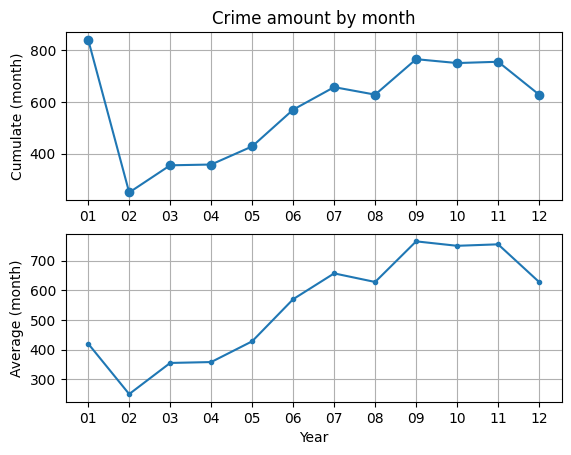

In [24]:
# Plot visualisations

import matplotlib.pyplot as plt
import numpy as np

y = monthArray
t = monthTotalArray
a = monthAvgArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by month')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()

In [25]:
# Create dataframe to retrieve information by year (total and average)
yearlyCrimeAmount = sqlContext.sql("select substring(Month, 0, 4) \
as Year, SUM(count) as Total, avg(count) as Average from \
tbl_LondonCrimes2 group by substring(Month, 0, 4)")


In [26]:
yearlyCrimeAmount

DataFrame[Year: string, Total: bigint, Average: double]

In [27]:
yearlyCrimeAmount.show()

+----+-----+-----------------+
|Year|Total|          Average|
+----+-----+-----------------+
|2022|  593|            593.0|
|2021| 6391|532.5833333333334|
+----+-----+-----------------+



In [28]:
# Register the yearly data in a temp table and show the contents
yearlyCrimeAmount.registerTempTable("yearlyCrimeAmount")
sqlContext.sql("select * from yearlyCrimeAmount").show()

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


+----+-----+-----------------+
|Year|Total|          Average|
+----+-----+-----------------+
|2022|  593|            593.0|
|2021| 6391|532.5833333333334|
+----+-----+-----------------+



In [29]:
# Prepare variables for visualisations

totalArray = sqlContext.sql("select Total from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()
averageArray = sqlContext.sql("select Average from yearlyCrimeAmount")\
.rdd.map(lambda f:f[0]).collect()

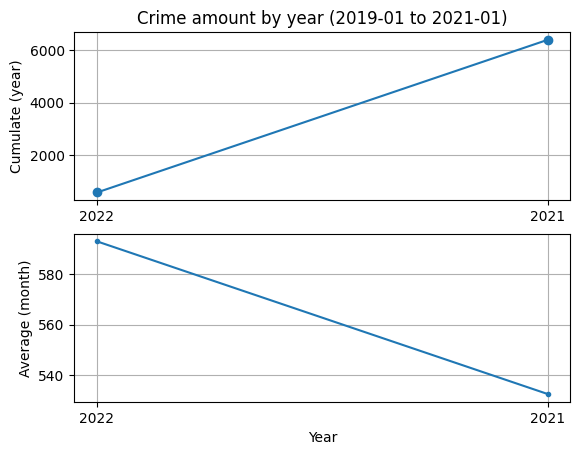

In [30]:
# Plot visualisations
import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by year (2019-01 to 2021-01)')
plt.ylabel('Cumulate (year)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Year')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearlyCrimeAmount.png")
plt.show()

In [31]:
sqlContext.sql("select Month, substring(Month, 0, 4) \
as Year, count(*) as Count from tbl_LondonCrimes group by Month").show()

+-------+----+-----+
|  Month|Year|Count|
+-------+----+-----+
|2021-07|2021|  657|
|2021-11|2021|  755|
|2021-10|2021|  750|
|2021-12|2021|  628|
|2021-08|2021|  628|
|2021-09|2021|  765|
|2022-01|2022|  593|
|2021-04|2021|  358|
|2021-06|2021|  570|
|2021-03|2021|  355|
|2021-02|2021|  250|
|2021-05|2021|  428|
|2021-01|2021|  247|
+-------+----+-----+



In [32]:
LondonCrime.printSchema()

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last_outcome_category: string (nullable = true)
 |-- Context: string (nullable = true)



In [33]:
# Create a Temp Table

LondonCrime.registerTempTable("tbl_LondonCrimeTypes")

/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [34]:
# Explore Crime Types per year/month

CrimeTypes = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year,\
count(*) as Count from tbl_LondonCrimeTypes group by Month, Crime_type")


In [35]:
CrimeTypes.show()

+--------------------+-------+----+-----+
|          Crime_type|  Month|Year|Count|
+--------------------+-------+----+-----+
|Anti-social behav...|2021-10|2021|   95|
|Possession of wea...|2021-08|2021|    6|
|            Burglary|2021-12|2021|   25|
|       Bicycle theft|2021-11|2021|   26|
|               Drugs|2021-07|2021|   49|
|Violence and sexu...|2021-07|2021|  104|
|             Robbery|2021-07|2021|   15|
|Possession of wea...|2021-07|2021|    4|
|         Other crime|2021-11|2021|   19|
|            Burglary|2021-08|2021|   22|
|       Vehicle crime|2022-01|2022|   15|
|         Other theft|2021-12|2021|   83|
|             Robbery|2022-01|2022|    4|
|         Shoplifting|2022-01|2022|   56|
|       Bicycle theft|2021-07|2021|   26|
|         Other crime|2021-09|2021|   14|
|Anti-social behav...|2022-01|2022|   78|
|Criminal damage a...|2021-08|2021|   30|
|       Bicycle theft|2021-12|2021|   11|
|         Shoplifting|2021-09|2021|   74|
+--------------------+-------+----

In [36]:
# Explore Crime Types per year/month

CrimeTypesGeo = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year, Latitude, Longitude, \
count(*) as Count from tbl_LondonCrimeTypes group by Month, \
Crime_type, Latitude, Longitude")
